# 1. Buoyancy Frequency Profile

To be in accordance with TEOS-10 it translates from Salinity_[psu] & Temp_[°C] into Absolute_Salinity [g/kg] & Conservative_Temp_deg [°C]. As sources I used the TEOS-10 book, some ChatGPT, lots of StackOverflow or Python Library Documentations (which I can easily quote), and also Work/Study coding experience for which giving sources like "my own memory" isnt feasible.

Precise explanations to be found in the code

## Density Calculation

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import gsw

# Paths
UDASH_FILE = Path("UDASH/ArcticOcean_phys_oce_2010.txt")
OUTPUT_DIR = Path("Density")
MISSING_VALUE = -999.0

# CHATGPT: Finding the year within the txt
def _infer_year_from_timestamp(series: pd.Series) -> str:
    """Try to infer a year from the yyyy-mm-ddThh:mm column."""
    s = series.dropna().astype(str)
    if s.empty:
        return "unknown"
    first = s.iloc[0]
    try:
        return str(pd.to_datetime(first).year)
    except Exception:
        return str(first)[:4]

# CHATGPT: Read raw UDASH file
def process_udash_file(path: Path, output_dir: Path = OUTPUT_DIR) -> tuple[pd.DataFrame, Path]:
    df = pd.read_csv(
        path,
        delim_whitespace=True,
        na_values=[MISSING_VALUE],
        engine="python",
    )

    # Replace explicit missing flag just in case
    df = df.replace(MISSING_VALUE, np.nan)

    # Make sure key columns exist
    required_cols = [
        "Prof_no",
        "Cruise",
        "Station",
        "Platform",
        "Type",
        "yyyy-mm-ddThh:mm",
        "Longitude_[deg]",
        "Latitude_[deg]",
        "Pressure_[dbar]",
        "Depth_[m]",
        "Temp_[°C]",
        "Salinity_[psu]",
    ]
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns in UDASH file: {missing}")

    # Sort so casts stay together and levels are ordered
    sort_keys = [
        "Prof_no",
        "yyyy-mm-ddThh:mm",
        "Depth_[m]",
        "Pressure_[dbar]",
    ]
    sort_keys = [k for k in sort_keys if k in df.columns]
    df = df.sort_values(sort_keys).reset_index(drop=True)

    # TEOS-10 inputs
    SP = df["Salinity_[psu]"].to_numpy(float)
    t = df["Temp_[°C]"].to_numpy(float)
    p = df["Pressure_[dbar]"].to_numpy(float)
    lon = df["Longitude_[deg]"].to_numpy(float)
    lat = df["Latitude_[deg]"].to_numpy(float)

    # ChatGPT: Range-based masking
    def _mask_range(arr, lo, hi):
        bad = (arr < lo) | (arr > hi)
        arr = arr.copy()
        arr[bad] = np.nan
        return arr
    
    # ChatGPT: Range-based masking (only values within masked range)
    lat = _mask_range(lat, -90, 90)
    lon = _mask_range(lon, -180, 360)
    p = _mask_range(p, 0, 12000)
    SP = _mask_range(SP, 0, 50)
    t = _mask_range(t, -5, 40)

    # TEOS-10 computations (Source: TEOS-10 webpage)
    SA = gsw.SA_from_SP(SP, p, lon, lat)           # Absolute salinity [g/kg]
    CT = gsw.CT_from_t(SA, t, p)                   # Conservative temperature [°C]
    rho = gsw.rho(SA, CT, p)                       # In-situ density [kg/m³]
    sigma0 = gsw.sigma0(SA, CT) + 1000.0           # Potential density σ0 + 1000

    # Attach TEOS-10 variables + source_file
    df = df.copy()
    df.insert(0, "source_file", path.name)
    df["Absolute_Salinity_g_kg"] = SA
    df["Conservative_Temp_degC"] = CT
    df["Density_kg_m3"] = rho
    df["Potential_Density_kg_m3"] = sigma0

    # Build output path with year tag
    year = _infer_year_from_timestamp(df["yyyy-mm-ddThh:mm"])
    output_dir.mkdir(parents=True, exist_ok=True)
    out_path = output_dir / f"{year}_{path.stem}_teos10.txt"

    # Choose column order for TEOS-10 file (I prefer to save more rather than less)
    out_cols = [
        "source_file",
        "Prof_no",
        "yyyy-mm-ddThh:mm",
        "Longitude_[deg]",
        "Latitude_[deg]",
        "Pressure_[dbar]",
        "Depth_[m]",
        "Temp_[°C]",
        "Salinity_[psu]",
        "Absolute_Salinity_g_kg",
        "Conservative_Temp_degC",
        "Density_kg_m3",
        "Potential_Density_kg_m3",
    ]
    out_cols = [c for c in out_cols if c in df.columns]

    # Write nicely sorted TEOS-10 file
    df[out_cols].to_csv(
        out_path,
        sep="\t",
        index=False,
        float_format="%.6f",
    )

    print(f"Loaded {len(df)} rows from {path}")
    print(f"TEOS-10 file written to: {out_path}")
    return df, out_path


# EXECUTION
df_teos10, teos10_path = process_udash_file(UDASH_FILE)

# Show a quick preview
df_teos10.head()

/tmp/ipykernel_30160/4041269985.py:25: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


Loaded 4222752 rows from UDASH/ArcticOcean_phys_oce_2010.txt
TEOS-10 file written to: Density/2010_ArcticOcean_phys_oce_2010_teos10.txt


,source_file,Prof_no,Cruise,Station,Platform,Type,yyyy-mm-ddThh:mm,Longitude_[deg],Latitude_[deg],Pressure_[dbar],...,Salinity_[psu],QF.2,Source,DOI,WOD-Cruise-ID,WOD-Cast-ID,Absolute_Salinity_g_kg,Conservative_Temp_degC,Density_kg_m3,Potential_Density_kg_m3
0,ArcticOcean_phys_oce_2010.txt,12202,JOHAN_HJORT,0023,S,CTD,2010-01-24T01:34,12.2835,69.0342,5.0,...,35.2074,0,ices,NaN,NaN,NaN,35.374720,7.293950,1027.563862,1027.541038
1,ArcticOcean_phys_oce_2010.txt,12202,JOHAN_HJORT,0023,S,CTD,2010-01-24T01:34,12.2835,69.0342,6.0,...,35.2075,0,ices,NaN,NaN,NaN,35.374825,7.293853,1027.568522,1027.541134
2,ArcticOcean_phys_oce_2010.txt,12202,JOHAN_HJORT,0023,S,CTD,2010-01-24T01:34,12.2835,69.0342,7.0,...,35.2077,0,ices,NaN,NaN,NaN,35.375031,7.293755,1027.573261,1027.541308
3,ArcticOcean_phys_oce_2010.txt,12202,JOHAN_HJORT,0023,S,CTD,2010-01-24T01:34,12.2835,69.0342,8.0,...,35.2076,0,ices,NaN,NaN,NaN,35.374935,7.294660,1027.577620,1027.541104
4,ArcticOcean_phys_oce_2010.txt,12202,JOHAN_HJORT,0023,S,CTD,2010-01-24T01:34,12.2835,69.0342,9.0,...,35.2079,0,ices,NaN,NaN,NaN,35.375241,7.293562,1027.582581,1027.541500


## Buoyancy Calculation

From the just calculated density I here now calculate the buoyancy profile for all the casts in a given year.


In [36]:
from pathlib import Path
import numpy as np
import pandas as pd
import gsw

# Define tunable QC thresholds for the quality control parameter that will be introduced later
MIN_DEPTH_RANGE_OK = 200.0   # [m] minimum depth range to be "acceptable"
MIN_DEPTH_RANGE_GOOD = 400.0 # [m] minimum depth range to be "good"
MAX_GAP_GOOD = 50.0          # [m] maximum vertical gap to still call it "good"

# Path
UDASH_FILE = Path("UDASH/ArcticOcean_phys_oce_2010.txt")
TEOS_DIR = Path("Density")
N2_DIR = Path("N2")

# CHATGPT: Find the TEOS-10 file produced earlier (For some reason I can never grasp how to retrieve paths...)
pattern = f"*_{UDASH_FILE.stem}_teos10.txt"
teos_files = sorted(TEOS_DIR.glob(pattern))
if not teos_files:
    raise FileNotFoundError(f"No TEOS-10 file matching {pattern} in {TEOS_DIR}")
TEOS10_FILE = teos_files[0]

# Load TEOS-10 data
df = pd.read_csv(TEOS10_FILE, sep="\t")

def compute_N2_for_cast(g: pd.DataFrame) -> pd.DataFrame | None:
    """
    Compute N2 for a single cast, keeping metadata and QC (quality control parameters).

    QC includes:
      - Chelton style overwriting of negative N2
      - Depth range of the profile
      - Maximum vertical gap introduction for the gridding
      - Quality flag N2_QC_flag:
          0 = poor (too shallow / very gappy (as defined from the QC thresholds))
          1 = acceptable (depth range >= MIN_DEPTH_RANGE_OK)
          2 = good (depth range >= MIN_DEPTH_RANGE_GOOD and max gap <= MAX_GAP_GOOD)
    """
    # sort after pressure per cast
    g = g.sort_values("Pressure_[dbar]").dropna(
        subset=["Absolute_Salinity_g_kg", "Conservative_Temp_degC",
                "Density_kg_m3", "Pressure_[dbar]", "Latitude_[deg]"]
    )
    if len(g) < 3:
        return None

    # gsw only takes floating point numbers
    SA = g["Absolute_Salinity_g_kg"].to_numpy(float)
    CT = g["Conservative_Temp_degC"].to_numpy(float)
    p = g["Pressure_[dbar]"].to_numpy(float)
    rho = g["Density_kg_m3"].to_numpy(float)
    lat = float(g["Latitude_[deg]"].iloc[0])

    # N2 and mid-pressure as gsw is defined (as in Pinner et al 2025)
    N2_raw, p_mid = gsw.Nsquared(SA, CT, p, lat)
    if N2_raw.size == 0:
        return None

    # as in Chelton et al 1998
    # negative N2(z_k) → N2(z_{k-1}); if shallowest N2(z_1) < 0 → 1e-8
    N2_fixed = N2_raw.copy()
    for k in range(len(N2_fixed)):
        if N2_fixed[k] < 0:
            if k == 0:
                N2_fixed[k] = 1e-8  # s^-2 at shallowest level
            else:
                N2_fixed[k] = N2_fixed[k - 1]
    N2 = N2_fixed

    # depth and mid-point variables (as in Pinner et al 2025) because gsw uses midpoint depths
    z_mid = -gsw.z_from_p(p_mid, lat)  # positive definitive depth
    SA_mid = 0.5 * (SA[:-1] + SA[1:])
    CT_mid = 0.5 * (CT[:-1] + CT[1:])
    rho_mid = 0.5 * (rho[:-1] + rho[1:])

    """
    QC metrics: depth range, max vertical gap, number of levels
    
    What makes a good quality result? The positive definitiveness of N2 is already ensured. For plotting purposes it is benefitial
    have data in regular, reasnable distances which are somewhat evenly spaced, dont vary too much in amount of levels between
    individual casts. The spatial (lat-lon) relation shall not be considered here, as we want to have variation in that realm. 
    
    Large values of N2 shall further not be incorporated either, as they might highlight patterns or measurement errors.
    """
    if z_mid.size > 0:
        depth_range = float(z_mid.max() - z_mid.min())
    else:
        depth_range = 0.0

    if z_mid.size > 1:
        dz = np.diff(z_mid)
        max_gap = float(np.max(dz))
    else:
        dz = np.array([])
        max_gap = np.nan

    n_levels = int(z_mid.size)

    # Quality flag
    # 0 = poor, 1 = acceptable, 2 = good
    qc_flag = 0
    if depth_range >= MIN_DEPTH_RANGE_OK:
        qc_flag = 1
    if (depth_range >= MIN_DEPTH_RANGE_GOOD) and np.isfinite(max_gap) and (max_gap <= MAX_GAP_GOOD):
        qc_flag = 2

    # construct columns again
    first = g.iloc[0]
    return pd.DataFrame({
        "source_file": first["source_file"],
        "Prof_no": first["Prof_no"],
        "yyyy-mm-ddThh:mm": first["yyyy-mm-ddThh:mm"],
        "Longitude_[deg]": first["Longitude_[deg]"],
        "Latitude_[deg]": first["Latitude_[deg]"],
        "Pressure_[dbar]": p_mid,
        "Depth_[m]": z_mid,
        "Absolute_Salinity_[g/kg]": SA_mid,
        "Conservative_Temperature_[°C]": CT_mid,
        "In-situ_Density_[kg m^-3]": rho_mid,
        "N2_[s^-2]": N2,
        # QC columns repeated for all rows per cast (easier than to create additional file per cast or to build hashmaps)
        "Depth_range_[m]": depth_range,
        "Max_gap_[m]": max_gap,
        "N_levels": n_levels,
        "N2_QC_flag": qc_flag,
    })

# Compute N2 for all casts (For-Loop Friederike mentioned in her mail, though I feel like it is easier to include it from the start)
pieces = []
for pid, gcast in df.groupby("Prof_no"):
    out = compute_N2_for_cast(gcast)
    if out is not None:
        pieces.append(out)

# Error message so as not to just get a Python error
if not pieces:
    raise RuntimeError("No valid casts for N² computation.")

dfN2 = pd.concat(pieces, ignore_index=True)

# Ensure sorting: by profile, then depth, then pressure
dfN2 = dfN2.sort_values(
    ["Prof_no", "Depth_[m]", "Pressure_[dbar]"]
).reset_index(drop=True)

# CHATGPT: Build output path and save
N2_DIR.mkdir(parents=True, exist_ok=True)
year_tag = TEOS10_FILE.stem.split("_", 1)[0]  # e.g. "1980"
out_path = N2_DIR / f"N2_{year_tag}_{UDASH_FILE.stem}.txt"

cols_out = [
    "source_file",
    "Prof_no",
    "yyyy-mm-ddThh:mm",
    "Longitude_[deg]",
    "Latitude_[deg]",
    "Pressure_[dbar]",
    "Depth_[m]",
    "Absolute_Salinity_[g/kg]",
    "Conservative_Temperature_[°C]",
    "In-situ_Density_[kg m^-3]",
    "N2_[s^-2]",
    "Depth_range_[m]",
    "Max_gap_[m]",
    "N_levels",
    "N2_QC_flag",
]
cols_out = [c for c in cols_out if c in dfN2.columns]

# CHATGPT: saves the DataFrame as a tab-separated text file
dfN2[cols_out].to_csv(
    out_path,
    sep="\t",
    index=False,
    float_format="%.6e",
)

print(f"Computed N² for {dfN2['Prof_no'].nunique()} casts "
      f"({len(dfN2)} midpoints).")
print(f"N² file written to: {out_path}")

dfN2.head()


Computed N² for 8607 casts (4199007 midpoints).
N² file written to: N2/N2_2010_ArcticOcean_phys_oce_2010.txt


,source_file,Prof_no,yyyy-mm-ddThh:mm,Longitude_[deg],Latitude_[deg],Pressure_[dbar],Depth_[m],Absolute_Salinity_[g/kg],Conservative_Temperature_[°C],In-situ_Density_[kg m^-3],N2_[s^-2],Depth_range_[m],Max_gap_[m],N_levels,N2_QC_flag
0,ArcticOcean_phys_oce_2010.txt,12202,2010-01-24T01:34,12.2835,69.0342,5.5,5.444562,35.374773,7.293902,1027.566192,9.259791e-07,1478.553034,0.994714,1500,2
1,ArcticOcean_phys_oce_2010.txt,12202,2010-01-24T01:34,12.2835,69.0342,6.5,6.434467,35.374928,7.293804,1027.570892,1.689016e-06,1478.553034,0.994714,1500,2
2,ArcticOcean_phys_oce_2010.txt,12202,2010-01-24T01:34,12.2835,69.0342,7.5,7.424367,35.374983,7.294208,1027.575441,1.689016e-06,1478.553034,0.994714,1500,2
3,ArcticOcean_phys_oce_2010.txt,12202,2010-01-24T01:34,12.2835,69.0342,8.5,8.414262,35.375088,7.294111,1027.580100,3.827017e-06,1478.553034,0.994714,1500,2
4,ArcticOcean_phys_oce_2010.txt,12202,2010-01-24T01:34,12.2835,69.0342,9.5,9.404152,35.375043,7.293517,1027.584714,3.827017e-06,1478.553034,0.994714,1500,2


# Buoyancy Example Cast

Lets just plot one individual cast to make sure the resulting Buoyancy Profile appears physically reasonable.
That plotting cell is not Step 3.
It only reads the native N2 profile and visualizes it, does no interpolation to a regular vertical grid and doesn’t change the data.

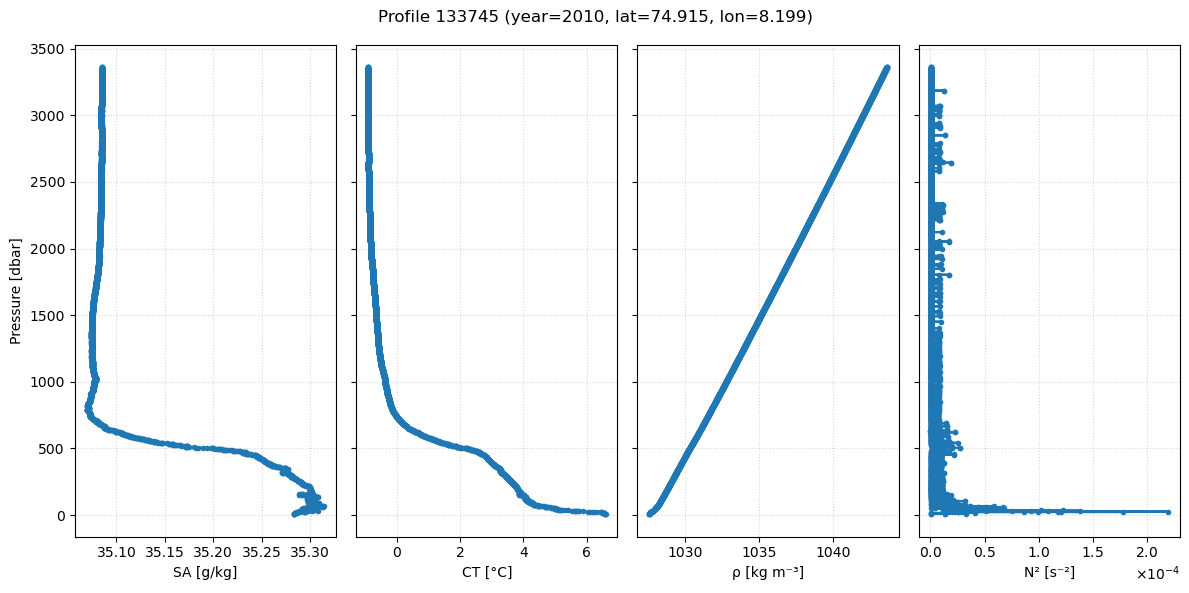

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter
from pathlib import Path


year = 2010            
profile_id = 133745       

# Load UDASH file for that year
UDASH_FILE = Path(f"UDASH/ArcticOcean_phys_oce_{year}.txt")
TEOS_DIR = Path("Density")

# CHATGPT: ensures you get the correct TEOS-10 file associated with the UDASH file by searching for a pattern
pattern_teos = f"*_{UDASH_FILE.stem}_teos10.txt"
teos_files = sorted(TEOS_DIR.glob(pattern_teos))
if not teos_files:
    raise FileNotFoundError(f"No TEOS-10 file matching {pattern_teos}")

TEOS10_FILE = teos_files[0]
df_teos10 = pd.read_csv(TEOS10_FILE, sep="\t")

# CHATGPT: Load N2 file for that year the same way like the TEOS-10 file
N2_DIR = Path("N2")
n2_file = N2_DIR / f"N2_{year}_{UDASH_FILE.stem}.txt"
if not n2_file.exists():
    raise FileNotFoundError(f"N2 file not found: {n2_file}")

dfN2 = pd.read_csv(n2_file, sep="\t")

# Select the chosen cast from both files
g_teos = (
    df_teos10[df_teos10["Prof_no"] == profile_id]
    .sort_values("Pressure_[dbar]")
)

g_n2 = (
    dfN2[dfN2["Prof_no"] == profile_id]
    .sort_values("Pressure_[dbar]")
)

# Give a warning if one file doesnt have that cast
if g_teos.empty:
    raise RuntimeError(f"Cast {profile_id} not found in TEOS-10 file for year {year}")

if g_n2.empty:
    raise RuntimeError(f"Cast {profile_id} not found in N2 file for year {year}")

# Extract variables and make them into float agsin
p = g_teos["Pressure_[dbar]"].to_numpy()
SA = g_teos["Absolute_Salinity_g_kg"].to_numpy()
CT = g_teos["Conservative_Temp_degC"].to_numpy()
rho = g_teos["Density_kg_m3"].to_numpy()

p_mid = g_n2["Pressure_[dbar]"].to_numpy()
N2v = g_n2["N2_[s^-2]"].to_numpy()

# Plot
fig, axes = plt.subplots(1, 4, figsize=(12, 6), sharey=True)

axes[0].plot(SA, p, marker=".")
axes[0].set_xlabel("SA [g/kg]")
axes[0].set_ylabel("Pressure [dbar]")

axes[1].plot(CT, p, marker=".")
axes[1].set_xlabel("CT [°C]")

axes[2].plot(rho, p, marker=".")
axes[2].set_xlabel("ρ [kg m⁻³]")

axes[3].plot(N2v, p_mid, marker=".")
axes[3].set_xlabel("N² [s⁻²]")

# I prefer scientific notation for the buoyancy frequencies
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
axes[3].xaxis.set_major_formatter(formatter)
axes[3].ticklabel_format(style="sci", axis="x", scilimits=(0, 3))

# Inverts the axis because pressure and depth are inversely related
for ax in axes:
    ax.invert_yaxis()
    ax.grid(True, linestyle=":", alpha=0.5)

# Lat & Lon of the FIRST measurement per cast
lat = g_teos["Latitude_[deg]"].iloc[0]
lon = g_teos["Longitude_[deg]"].iloc[0]

fig.suptitle(
    f"Profile {profile_id} (year={year}, lat={lat:.3f}, lon={lon:.3f})",
    y=0.98
)

plt.tight_layout()
plt.show()


For one cast (one Prof_no) this code takes the mid-point depths and N2 from dfN2 (Depth_[m], N2_[s^-2] for that Prof_no and year), then does a check to only proceed if N2_QC_flag is at least 1 or 2.

Afterwards I define a regular depth grid (e.g. Δz = 5–10 m or the median native Δz) which I can simply adapt on the go.

Finally to interpolate N²(z) from the irregular z_mid to the regular z_reg, so as not only to have the pressure plot as above.

Preparing cast Prof_no=133745 (year=2010) for EVP
  N2_QC_flag = 2, depth_range = 3293.9 m, max_gap = 1.4 m
  Regular grid: 3300 levels, dz ≈ 1.00 m
  Time: 2010-07-13 18:22:00  (month=7)


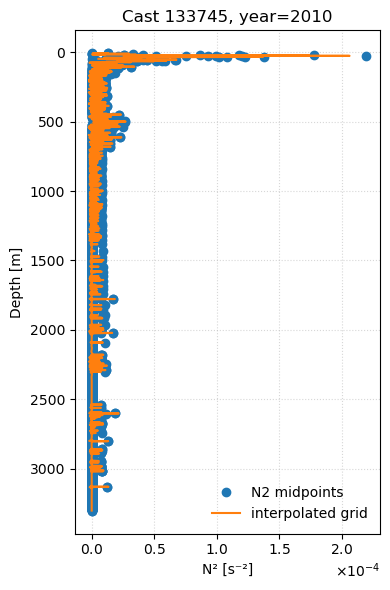

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.ticker import ScalarFormatter



year = 2010           # year of interest
profile_id = 133745      # Prof_no to prepare for EVP
dz_target = None      # if None -> use median native Δz; else set as one likes

# Load N2 file for that year
UDASH_FILE = Path(f"UDASH/ArcticOcean_phys_oce_{year}.txt")
N2_DIR = Path("N2")
n2_file = N2_DIR / f"N2_{year}_{UDASH_FILE.stem}.txt"

# Error if that file doesnt exit
if not n2_file.exists():
    raise FileNotFoundError(f"N2 file not found: {n2_file}")

dfN2 = pd.read_csv(n2_file, sep="\t")

# Cast out the non-casted casts to keep the casted cast
g = (
    dfN2[dfN2["Prof_no"] == profile_id]
    .sort_values("Depth_[m]")
    .dropna(subset=["Depth_[m]", "N2_[s^-2]"])
)

# Cast-check the cast table. If the casted cast is castless, cast a RuntimeError for the cast-year.
if g.empty:
    raise RuntimeError(f"Cast {profile_id} not found in N2 file for year {year}")

# QC info since it´s best to just ignore the 0´s
qc_flag = g["N2_QC_flag"].iloc[0] if "N2_QC_flag" in g.columns else np.nan
depth_range = g["Depth_range_[m]"].iloc[0] if "Depth_range_[m]" in g.columns else np.nan
max_gap = g["Max_gap_[m]"].iloc[0] if "Max_gap_[m]" in g.columns else np.nan

print(f"Preparing cast Prof_no={profile_id} (year={year}) for EVP")
print(f"  N2_QC_flag = {qc_flag}, depth_range = {depth_range:.1f} m, max_gap = {max_gap:.1f} m")

# Native mid-point depth and N2 to float
z_mid = g["Depth_[m]"].to_numpy(float)
N2_mid = g["N2_[s^-2]"].to_numpy(float)

# Ensure we have enough levels per cast to yield a physically meaningful profile
if z_mid.size < 3:
    raise RuntimeError("Too few N² levels to build a useful regular grid.")

# Define regular depth grid from the mid-depths as is intrinsic to Chelton and the gsw function
dz_native = np.diff(z_mid)
dz_med = float(np.median(dz_native)) if dz_native.size > 0 else np.nan

# Define substitution seperation
if dz_target is None:
    dz = dz_med
else:
    dz = float(dz_target)

if not np.isfinite(dz) or dz <= 0:
    raise RuntimeError(f"Could not determine a positive dz (dz_native_med = {dz_med})")

zmin, zmax = float(z_mid.min()), float(z_mid.max())
z_reg = np.arange(zmin, zmax + 0.5 * dz, dz)  # include top & bottom

# Interpolate N2 onto regular grid how I learned it
#N2_reg = np.interp(z_reg, z_mid, N2_mid)

# CHATGPT
# Interpolate N2 onto regular grid with a smooth spline
# s = 0 -> passes exactly through the data (already much smoother than np.interp)
# increase s for more smoothing, e.g. s=len(z_mid)*np.var(N2_mid)*0.1
from scipy.interpolate import UnivariateSpline
spline = UnivariateSpline(z_mid, N2_mid, s=0.000000005)
N2_reg = spline(z_reg)


# Grab metadata (lat, lon, time, month) from the first part of the cast
lat = float(g["Latitude_[deg]"].iloc[0])
lon = float(g["Longitude_[deg]"].iloc[0])

cast_time = None
cast_month = None
if "yyyy-mm-ddThh:mm" in g.columns:
    try:
        cast_time = pd.to_datetime(g["yyyy-mm-ddThh:mm"].iloc[0])
        cast_month = cast_time.month
    except Exception:
        pass

print(f"  Regular grid: {z_reg.size} levels, dz ≈ {dz:.2f} m")
if cast_month is not None:
    print(f"  Time: {cast_time}  (month={cast_month})")

# Quick diagnostic plot: pointwise vs interpolated N2
fig, ax = plt.subplots(figsize=(4, 6))

ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis="x", style="sci", scilimits=(0, 2))

ax.plot(N2_mid, z_mid, "o", label="N2 midpoints")
ax.plot(N2_reg, z_reg, "-", label="interpolated grid")
ax.invert_yaxis()
ax.set_xlabel("N² [s⁻²]")
ax.set_ylabel("Depth [m]")
ax.grid(True, linestyle=":", alpha=0.5)
ax.legend(frameon=False)
ax.set_title(f"Cast {profile_id}, year={year}")

plt.tight_layout()
plt.show()

# z_reg and N2_reg are now ready for EVP (Step 4–5)


I am thinking that an uncertainty calculation is needed due to the error propagation. Perhaps the MAD-based Method found in the Git Repository of Pollmann et.al. can be adapted to this here?

It is furthermore worthwile to retrieve an overall profile for a given year, despite seasonal variations, just to make sure it overall behaves somewhat physical.

# Upper Meters
For now I decided to keep the upper meters included in the profiles, especially since excluding them would just mean slight changes in the buoyancy calculation cell and interpolation cell. At least thats what I believe prior to having done that! :)

Year 2010: 5356 casts with N2_QC_flag >= 2
Included 5356 casts in the average profile.


/tmp/ipykernel_28586/533555326.py:74: RuntimeWarning: Mean of empty slice
  mean_N2 = np.nanmean(N2_stack, axis=0)
/home/conda/envs/ocean/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1216: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a, func=_nanmedian, keepdims=keepdims,


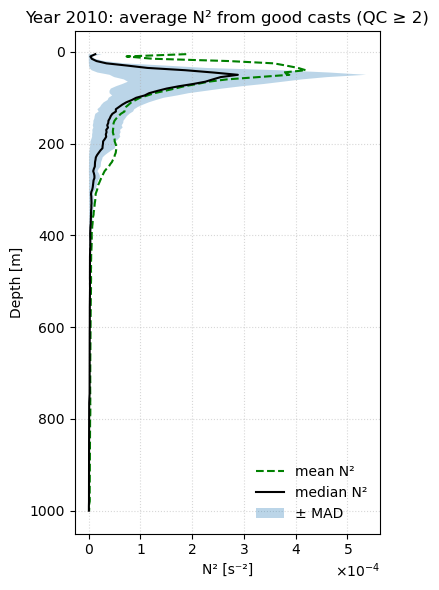

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.ticker import ScalarFormatter


# SETTINGS
year = 2010           
qc_min = 2            # minimum N2_QC_flag to accept
z_min = 0.0           # depth range for common grid [m]
z_max = 1000.0         
dz = 5.0              # grid spacing [m]

# Load N2 file for given year
UDASH_FILE = Path(f"UDASH/ArcticOcean_phys_oce_{year}.txt")
N2_DIR = Path("N2")
n2_file = N2_DIR / f"N2_{year}_{UDASH_FILE.stem}.txt"

# Again, integrating an error message is always better than relaying on Python error messages
if not n2_file.exists():
    raise FileNotFoundError(f"N2 file not found: {n2_file}")

dfN2 = pd.read_csv(n2_file, sep="\t")

# Select "good" casts by QC flag
if "N2_QC_flag" not in dfN2.columns:
    raise RuntimeError("Column 'N2_QC_flag' not found. "
                       "Make sure you ran the QC-aware N² cell.")

# Copy the good casts
good = dfN2[dfN2["N2_QC_flag"] >= qc_min].copy()
if good.empty:
    raise RuntimeError(f"No casts with N2_QC_flag >= {qc_min} for year {year}.")

# Retain the approved cast id´s
cast_ids = good["Prof_no"].unique()
print(f"Year {year}: {len(cast_ids)} casts with N2_QC_flag >= {qc_min}")

# Build common depth grid at the midpoints
z_grid = np.arange(z_min, z_max + dz/2, dz)
nz = z_grid.size

# Matrix to hold N2(z) per cast on common grid
N2_stack = []

# Loop that checks each N2 wether it is in an approved cast and then turns it into float
for cid in cast_ids:
    g = (
        good[good["Prof_no"] == cid]
        .sort_values("Depth_[m]")
        .dropna(subset=["Depth_[m]", "N2_[s^-2]"])
    )
    if g.empty or g["Depth_[m]"].nunique() < 3:
        continue

    z_mid = g["Depth_[m]"].to_numpy(float)
    N2_mid = g["N2_[s^-2]"].to_numpy(float)

# interpolate to z_grid and set values outside native range to NaN
    z_lo, z_hi = z_mid.min(), z_mid.max()
    N2_interp = np.interp(z_grid, z_mid, N2_mid)
    mask_outside = (z_grid < z_lo) | (z_grid > z_hi)
    N2_interp[mask_outside] = np.nan

    N2_stack.append(N2_interp)

# We cant interpolate if there is nothing to interpolate
N2_stack = np.array(N2_stack)
if N2_stack.size == 0:
    raise RuntimeError("No valid casts for interpolation on common grid.")

print(f"Included {N2_stack.shape[0]} casts in the average profile.")

# Compute average profiles (mean, median, MAD) as in Pinner et al 2025
mean_N2 = np.nanmean(N2_stack, axis=0)
median_N2 = np.nanmedian(N2_stack, axis=0)
mad_N2 = np.nanmedian(np.abs(N2_stack - median_N2), axis=0)

# Plot average N2 profiles
fig, ax = plt.subplots(figsize=(4, 6))


ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis="x", style="sci", scilimits=(0, 2))


ax.plot(mean_N2, z_grid, "g--", label="mean N²")
ax.plot(median_N2, z_grid, "k-", label="median N²")

# show MAD envelope
ax.fill_betweenx(
    z_grid,
    median_N2 - mad_N2,
    median_N2 + mad_N2,
    alpha=0.3,
    label="± MAD"
)

ax.invert_yaxis()
ax.set_xlabel("N² [s⁻²]")
ax.set_ylabel("Depth [m]")
ax.grid(True, linestyle=":", alpha=0.5)
ax.legend(frameon=False)
ax.set_title(f"Year {year}: average N² from good casts (QC ≥ {qc_min})")

plt.tight_layout()
plt.show()


# 2. Creating the Eigenvalue Problem

- https://github.com/OceanLabPy/OceanLab/blob/master/examples/DYN_EOF.ipynb    (not this example, but maybe DYN.vmodes(...)
- https://www.d.umn.edu/~smkelly/software.html  (translate the .m into .py, ChatGPT might save time with this task)

- "The Vertical Mode Decomposition of Surface and Internal Tides in the Presence of a Free Surface and Arbitrary Topography" by Samuel L. Kelly 2016, although here I wonder if his assumptions even remotely agree with mine
- Kelly has some neat matlab codes on his website https://www.d.umn.edu/~smkelly/software.html with one named "modes.m". If one rewrites this into Python, then adapts it to my source files and adapt the EVP, it might actually do the trick. We simply have to retain the metadata for all the casts.
- Cheltons discretization 1998
- to better interpolate its best to bring the N2 values to somewhat of a comparable depth by sometimes assuming for some meters that the N2 profiles remain at the last known vertical value
- potentially one has to limit the EVP to omit the upper 20 or upper 50 meters due to the harsh variation of N2 there.

Try using known algorithms as Kelly and Oceanlab, then adapt them to Cheltons discretization and my .txt files, then solve while keeping the metadata. Afterwards there only needs to be the mapping!

# What happened?

I translated Kelly´s modes.m into Python with the help of ChatGPT and Stackoverflor and honestly often just general thinking as I am surprised by how straightforward and Python-like equations often are in Mathlab. Then I worked through the code and said Papers to check for similarities, then adapted it to the UDASH dataset and tried to change the equations to adapt it more to Cheltons approach.

It is heavily leaning on how Chelton (Rossby radius) formulated their 
    equations and how Kelly (2015) then wrote hus code & paper.

œœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœ
EXPLANATORY PROBLEM (I have the greek and norwegian alphabet on my PC, hence all the greek letters.)
œœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœœ

In essence one wants the vertical modes φ_n(z) and phase speeds c_n such that

    d2φ_n / dz2 + (N2(z) / c_n2) φ_n = 0           (1)

with boundary conditions consistent with a rigid lid at the surface
and a flat bottom. Kelly's code uses Neumann Boundary Conditions for φ:

    ∂φ/∂z = 0 at z = 0 (surface, rigid lid)       (2a)
    ∂φ/∂z = 0 at z = -H (bottom, flat bottom)     (2b)

From Chelton (1998) and likely also other literature one knows that the 
eigenvalue is k_n2 = 1 / c_n2. Then (1) becomes:

        d2φ_n / dz2 = -k_n2 N2(z) φ_n                (3)

Discretizing d2/dz2 with a finite-difference second-derivative
operator D2, and evaluating N2(z) on a suitable vertical grid,
gives a kind of generalized matrix eigenproblem:

        D2 * φ = k2 * A * φ                           (4)

where:
    - D2 is the discrete second-derivative matrix with BCs,
    - A = diag(-N2) (or here, -N2 evaluated on midpoints),
    - k2 is the eigenvalue, and c = 1 / sqrt(k2).
    
N2 is evaluated at the midpoints for the EVP ad N2 was calculated at the midpoints initially.
    
Compare that to Kelly's MODES.m does:

        D2 = ... 
        A = diag(-N2_tmp)
        [PHI, k2] = eigs(D2, A, Nm, 'SM', opts)

After the meeting where Friederike suggested using SciPy's eigh(), and after further translating 
modes.m with ChatGPT who WITHOUT EVEN ASKING told me to to use SciPy, I tried that.

### Parameters:

dz : Vertical grid spacing [m], assumed uniform andr Δz used to discretize d2/dz2 in (3).
N2 : Buoyancy frequency squared profile N²(z) [s⁻²] 
Nm : number of modes you want to return.
        - In Kelly’s MATLAB code, Nm is the number of modes to solve
          INCLUDING the barotropic one, but he subtracts one before
          calling eigs, because he does mode-0 analytically.
        - I did the same:
              if include_mode0:
                  we solve for Nm-1 baroclinic modes
              else:
                  we solve for Nm modes.
        - If Nm is None, we default to Nz - 1 (same as his code).
g : Gravitational acceleration [m s⁻²] which I kept constant as it will not have to much of an impart

### RESUKTS

PHI : Pressure/velocity structure eigenfunctions.
        - In Kelly's code, after solving the EVP on staggered points,
          he takes a vertical derivative:
             PHI = diff(PHI_full) / (-dz)

C : Eigenspeeds [m s⁻¹].
        - k² eigenvalues -> c = 1 / sqrt(k²), same as Kelly's:
             C = 1 ./ sqrt(k2);

PHI2 : Vertical-velocity structure eigenfunctions (W structure), simply included
            since Kelly included them too and we might need them, though IDK
        - Kelly defines PHI2 by averaging PHI between vertical levels:
             PHI2 = (PHI(k) + PHI(k+1)) / 2

In [15]:
import numpy as np
from scipy.linalg import eigh  


def modes_chelt_kelly(dz, N2, Nm=None, include_mode0=True, g=9.81):
    # 1. Basic set-up / dimensions
    # Make N2 to be a 1-D NumPy array of length N = Nz.
    N2 = np.asarray(N2).ravel()
    N = N2.size  # N corresponds to Nz in the modes.m
    H = dz * N   

    if Nm is None:
        Nm = N - 1  # Default number of modes if not specified

    if include_mode0:
        Nm_solve = Nm - 1   # number of baroclinic modes to solve numerically
    else:
        Nm_solve = Nm       # If we don't want barotropic mode, solve Nm

    if Nm_solve <= 0:
        raise ValueError("Nm must be at least 1 (or 2 if include_mode0=True).")

# 2. Build second-derivative matrix D2
    
#This is the finite-difference approximation in (3).
#Kelly defines an (N-1 x N-1) matrix D2 acting on values at the interfaces* between the N full levels (so there are N-1 gaps).

#The interior rows: standard second-order centered differences:
# (φ_{j-1} - 2 φ_j + φ_{j+1}) / dz2

    D2 = np.zeros((N - 1, N - 1), dtype=float)
    

# Kelly:
#   for i=2:N-2
#       D2(i,i-1)=1/dz^2; D2(i,i)=-2/dz^2; D2(i,i+1)=1/dz^2;
#   end

    
    for i in range(1, N - 2):
        D2[i, i - 1] =  1.0 / dz**2
        D2[i, i]     = -2.0 / dz**2
        D2[i, i + 1] =  1.0 / dz**2

    # Kelly implements boundary conditions by modifying the first and last rows of D2:
    #   D2(1,1) = -2/dz^2; D2(1,2) = 1/dz^2;
    #   D2(N-1,N-1) = -2/dz^2; D2(N-1,N-2) = 1/dz^2;

    D2[0, 0] = -2.0 / dz**2
    D2[0, 1] =  1.0 / dz**2

    D2[N - 2, N - 2] = -2.0 / dz**2
    D2[N - 2, N - 3] =  1.0 / dz**2



#2. Now "A" matrix: A = diag(-N2_tmp) 

#In equation (3), the right-hand side has N2(z) φ(z).
#Kelly builds A = diag(-N2_tmp), so that:

#    D2 * φ = k² * A * φ                        (4)

#So I already said that one has to use the midpoints fot the buoyancy frequency:
    
#    N2_tmp = (N2(1:end-1) + N2(2:end)) / 2 in MATLAB.


    N2_tmp = 0.5 * (N2[:-1] + N2[1:])  # shape: (N-1,)

    A = np.diag(-N2_tmp)


#3. Define how to solve EVP

#Original form:
    
#    D2 * φ = k² * diag(-N2_tmp) * φ

#Multiply by -1:
    
#    (-D2) * φ = k² * diag(N2_tmp) * φ

#This is mathematically identical, but the reason is now the "B matrix" is diag(N2_tmp), which is positive definite if N2_tmp > 0, 
#as required by scipy.linalg.eigh. And without this minor fix it would result in an error warning


    N2_tmp_clean = N2_tmp.copy()
    # Replace nonfinite by NaN 
    N2_tmp_clean[~np.isfinite(N2_tmp_clean)] = np.nan

    # If everything is bad, bail out of this profile
    if np.all(~np.isfinite(N2_tmp_clean)) or np.all(N2_tmp_clean <= 0):
        raise ValueError("N2_tmp is nonpositive or invalid everywhere for this profile.")

    A_mat = -D2
    B_mat = np.diag(N2_tmp_clean)

    # Solve: A_mat * φ = λ * B_mat * φ, λ = k2 weil Scipy die Definition so möcjhte
    evals, evecs = eigh(A_mat, B_mat)

    k2_all = evals
    PHI_all = evecs


    # Keep only Nm_solve necessary eigenvalues:
    k2 = k2_all[:Nm_solve].copy()
    PHI = PHI_all[:, :Nm_solve].copy()  # shape: (N-1, Nm_solve)

# 4. Convert eigenvalues k2 to phase speeds c
# Kelly:
#   k2 = diag(k2);
#   k2(k2 < 0) = Inf;
#   C = 1 ./ sqrt(k2);
#   [C, ind] = sort(C, 'descend');
#   PHI = PHI(:, ind);

    k2[k2 < 0] = np.inf          # ignore physically weird negative k
    C = 1.0 / np.sqrt(k2)       

    # Sort by eigenspeed (mode 1 = fastest baroclinic, etc.)
    ind = np.argsort(C)[::-1]    
    C = C[ind]
    PHI = PHI[:, ind]

# 5. Add boundary values & convert to W (PHI2) and U/P (PHI)
# Kelly:
#   PHI = [zeros(1,Nm); PHI; zeros(1,Nm)];
# extend φ at interfaces by zero at top and bottom to get a
# (N+1) x Nm_solve matrix (including ghost points).
    PHI_full = np.vstack([
        np.zeros((1, PHI.shape[1])),  # top boundary value
        PHI,
        np.zeros((1, PHI.shape[1]))   # bottom boundary value
    ])  # shape: (N+1, Nm_solve)

    # Average between points to get W structure"
    # Kelly:
    #   PHI2 = (PHI(1:end-1,:) + PHI(2:end,:)) / 2;

    PHI2 = 0.5 * (PHI_full[:-1, :] + PHI_full[1:, :])  # shape: (N, Nm_solve)

    # Take derivative to get U and P structure:
    # Kelly:
    #   PHI = diff(PHI) ./ (-dz);
    # so the sign is negative generally.
    PHI = -np.diff(PHI_full, axis=0) / dz             # shape: (N, Nm_solve)

# 6. Normalize PHI (U/P-structure) over the whole depth
# Kelly:
#   A = repmat(nansum(PHI.^2 .* dz,1) ./ H, [N 1]).^(1/2);
#   PHI = PHI ./ A;

#   For each mode n: sqrt(∫_0^H PHI_n(z)² dz / H) = 1

    A_norm = np.sqrt(np.nansum(PHI**2 * dz, axis=0) / H)  
    A_norm[A_norm == 0] = np.inf                          # avoid division by zero
    PHI = PHI / A_norm                                    

# 7. Normalize PHI2 (W-structure) with N2-weighting and C2
# Kelly:
#   A = repmat(nansum(PHI2.^2 .* N2 * dz,1) ./ (H * C.^2).',[N 1]).^(1/2);
#   PHI2 = PHI2 ./ A;

#   For each mode n:
#     sqrt( ∫ PHI2_n(z)² * N²(z) dz / (H * C_n²) ) = 1

# This ensures an energy-based normalization used in internal-wave mode decompositions.

    weight = N2[:, None]  # shape (N,1)
    num = np.nansum(PHI2**2 * weight * dz, axis=0)  
    den = H * C**2                                  
    A2_norm = np.sqrt(num / den)                    
    A2_norm[A2_norm == 0] = np.inf
    PHI2 = PHI2 / A2_norm

# 8. make surface PHI positive again 
# Kelly:
#   PHI2(:, PHI(1,:)<0) = -PHI2(:, PHI(1,:)<0);
#   PHI(:,  PHI(1,:)<0) = -PHI(:,  PHI(1,:)<0);

# He flips the sign of any mode for which the surface value is negative.

    mask = PHI[0, :] < 0  # which modes have negative surface PHI?
    PHI[:, mask] *= -1.0
    PHI2[:, mask] *= -1.0

# 9. Add the barotropic (mode-0) solution, if need be
# Kelly:
#   if flag_0==1
#       PHI  = [ones(N,1),  PHI ];
#       PHI2 = [zeros(N,1), PHI2];
#       C    = [sqrt(9.81*H); C];
#   end

# This corresponds to:
#   - barotropic mode: Φ0(z) = 1 (U/P structure is uniform in z)
#   - W structure: W0(z) = 0
#   - phase speed: c0 = sqrt(g * H) 
# From the book Ocean Dynamics
    if include_mode0:
        PHI = np.column_stack([np.ones((N, 1)), PHI])
        PHI2 = np.column_stack([np.zeros((N, 1)), PHI2])
        C = np.concatenate(([np.sqrt(g * H)], C))
        
    return PHI, C, PHI2


In [17]:
# 2. Solvin the Eigenvalue Problem FOR ENTIRE YEAR

import numpy as np
import pandas as pd
from pathlib import Path

years = list(range(1980, 2016))   
qc_min = 2         
Nm = 4             

# As always, the directories are presented to you by ChatGPT
N2_DIR = Path("N2")
UDASH_DIR = Path("UDASH")
MODES_DIR = Path("Modes")
MODES_DIR.mkdir(exist_ok=True)

all_rows = []      # will collect results from casts here

for year in years:
    print(f"\n YEAR {year} ")

    # CHATGPT This is the original UDASH file name pattern you used in Part 1
    udash_file = UDASH_DIR / f"ArcticOcean_phys_oce_{year}.txt"

    # CHATGPT Your N2 files are named like: N2_YYYY_ArcticOcean_phys_oce_YYYY.txt
    pattern_n2 = f"N2_*_{udash_file.stem}.txt"
    n2_files = sorted(N2_DIR.glob(pattern_n2))

    # Integrated Error Message if a Buoyancy File is nonexistant
    if not n2_files:
        print(f"  No N² file matching {pattern_n2} in {N2_DIR}")
        continue

    n2_file = n2_files[0]
    print(f"Using N² file: {n2_file}")

    dfN2 = pd.read_csv(n2_file, sep="\t")

    # Keep only "good" N2 according to QC flag
    good = dfN2[dfN2["N2_QC_flag"] >= qc_min].copy()
    if good.empty:
        print(f"  No casts with N2_QC_flag ≥ {qc_min}")
        continue

    cast_ids = good["Prof_no"].unique()
    print(f"  {len(cast_ids)} casts with N2_QC_flag ≥ {qc_min}")

    # Loop through all the casts to sort individual casts and handle them cast by cast so that later one can pick out individual casts
    # Saves a lot of time compared to programming it for one individual cast and then adapting my code to accomodate for all casts.
    # With this approach no changes are needed to do when we then study the temporal evolution, and individual casts are already
    # seperable, all in one.
    for cid in cast_ids:
        # All rows belonging to this profile
        g = (
            good[good["Prof_no"] == cid]
            .sort_values("Depth_[m]")
            .dropna(subset=["Depth_[m]", "N2_[s^-2]"])
        )

        # Need at least a few depth levels
        if g.empty or g["Depth_[m]"].nunique() < 3:
            continue

        # Used the native mid-depths that were implemented for the N2 calculationa and in the N2 file
        z_mid = g["Depth_[m]"].to_numpy(float)
        N2_mid = g["N2_[s^-2]"].to_numpy(float)

        dz_native = np.diff(z_mid)
        dz_med = float(np.median(dz_native)) if dz_native.size > 0 else np.nan
        if not np.isfinite(dz_med) or dz_med <= 0:
            continue

        dz = dz_med

        # Regular vertical grid for this cast specifically, so that one does not need to adapt height and resolutoin 
        z_reg = np.arange(z_mid.min(), z_mid.max() + 0.5 * dz, dz)
        N2_reg = np.interp(z_reg, z_mid, N2_mid)

        # Require at least a few valid N2 values on the regular grid
        if np.count_nonzero(np.isfinite(N2_reg)) < 3:
            continue

        # Solve the Chelton/Kelly EVP for given profile
        try:
            PHI, C, PHI2 = modes_chelt_kelly(
                dz=dz,
                N2=N2_reg,
                Nm=Nm,
                include_mode0=True,   # mode 0 = barotropic, mode 1 = first baroclinic, etc.
            )
        except Exception as exc:
            print(f"  Cast {cid}: EVP failed → {exc}")
            continue

        # Metadata
        first = g.iloc[0]
        lat = float(first["Latitude_[deg]"])
        lon = float(first["Longitude_[deg]"])
        tstr = first["yyyy-mm-ddThh:mm"]
        qc_flag = int(first["N2_QC_flag"])

        # Store everything in a row dictionary
        row = {
            "year": year,
            "Prof_no": int(cid),
            "time_str": tstr,
            "lat": lat,
            "lon": lon,
            "N2_QC_flag": qc_flag,
            "dz_used": dz,
            "z_min": float(z_reg.min()),
            "z_max": float(z_reg.max()),
        }

        # Eigenspeeds: C[0] = barotropic, C[1] = first baroclinic, etc.
        for im, c_val in enumerate(C):
            row[f"C_mode{im}"] = float(c_val)

        all_rows.append(row)

# CHATGPT Build one big DataFrame with modes for all casts / years
df_modes = pd.DataFrame(all_rows)

if df_modes.empty:
    print("\nNo modes were computed. Check years, qc_min, and N² file paths.")
else:
    # Insert time string into datetime for later temporal analysis
    df_modes["time"] = pd.to_datetime(df_modes["time_str"], errors="coerce")

    print(f"\nTotal casts with modes: {df_modes['Prof_no'].nunique()}")
    print("Columns in df_modes:", df_modes.columns.tolist())
    display(df_modes.head())

    # Gotta save it too
    modes_file = MODES_DIR / f"m_{years[0]}-{years[-1]}_eigencoeffs.txt"
    df_modes.to_csv(modes_file, sep="\t", index=False, float_format="%.6e")
    print(f"Saved modes to: {modes_file}")



 YEAR 1980 
Using N² file: N2/N2_1980_ArcticOcean_phys_oce_1980.txt


/tmp/ipykernel_19111/3739090792.py:37: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  dfN2 = pd.read_csv(n2_file, sep="\t")


  740 casts with N2_QC_flag ≥ 2

 YEAR 1981 
Using N² file: N2/N2_1981_ArcticOcean_phys_oce_1981.txt


/tmp/ipykernel_19111/3739090792.py:37: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  dfN2 = pd.read_csv(n2_file, sep="\t")


  711 casts with N2_QC_flag ≥ 2

 YEAR 1982 
  No N² file matching N2_*_ArcticOcean_phys_oce_1982.txt in N2

 YEAR 1983 
  No N² file matching N2_*_ArcticOcean_phys_oce_1983.txt in N2

 YEAR 1984 
  No N² file matching N2_*_ArcticOcean_phys_oce_1984.txt in N2

 YEAR 1985 
  No N² file matching N2_*_ArcticOcean_phys_oce_1985.txt in N2

 YEAR 1986 
  No N² file matching N2_*_ArcticOcean_phys_oce_1986.txt in N2

 YEAR 1987 
  No N² file matching N2_*_ArcticOcean_phys_oce_1987.txt in N2

 YEAR 1988 
  No N² file matching N2_*_ArcticOcean_phys_oce_1988.txt in N2

 YEAR 1989 
  No N² file matching N2_*_ArcticOcean_phys_oce_1989.txt in N2

 YEAR 1990 
  No N² file matching N2_*_ArcticOcean_phys_oce_1990.txt in N2

 YEAR 1991 
  No N² file matching N2_*_ArcticOcean_phys_oce_1991.txt in N2

 YEAR 1992 
  No N² file matching N2_*_ArcticOcean_phys_oce_1992.txt in N2

 YEAR 1993 
  No N² file matching N2_*_ArcticOcean_phys_oce_1993.txt in N2

 YEAR 1994 
  No N² file matching N2_*_ArcticOcean_phys

,year,Prof_no,time_str,lat,lon,N2_QC_flag,dz_used,z_min,z_max,C_mode0,C_mode1,C_mode2,C_mode3,time
0,1980,495,1980-03-20T18:49,70.263,17.035,2,4.949590,2.474636,848.854611,91.386777,0.646249,0.410526,0.266798,1980-03-20 18:49:00
1,1980,501,1980-05-05T20:34,69.145,16.295,2,4.948050,2.474802,432.955152,65.357116,0.665374,0.274165,0.208119,1980-05-05 20:34:00
2,1980,517,1980-08-13T08:22,68.443,-21.025,2,4.948390,2.474910,487.417130,69.324071,0.731076,0.337457,0.226708,1980-08-13 08:22:00
3,1980,518,1980-08-20T00:13,71.840,-11.025,2,4.947960,2.474414,502.218374,70.363540,0.811126,0.401511,0.297873,1980-08-20 00:13:00
4,1980,521,1980-08-30T19:23,80.260,6.055,2,4.945915,2.473516,502.010931,70.348998,0.629264,0.310643,0.201758,1980-08-30 19:23:00


Saved modes to: Modes/m_1980-2015_eigencoeffs.txt


# 4. Mapping the results

Computed 5 baroclinic modes (eigenspeeds):
Mode 1: c_n = 0.290 m/s
Mode 2: c_n = 0.128 m/s
Mode 3: c_n = 0.071 m/s
Mode 4: c_n = 0.055 m/s
Mode 5: c_n = 0.045 m/s


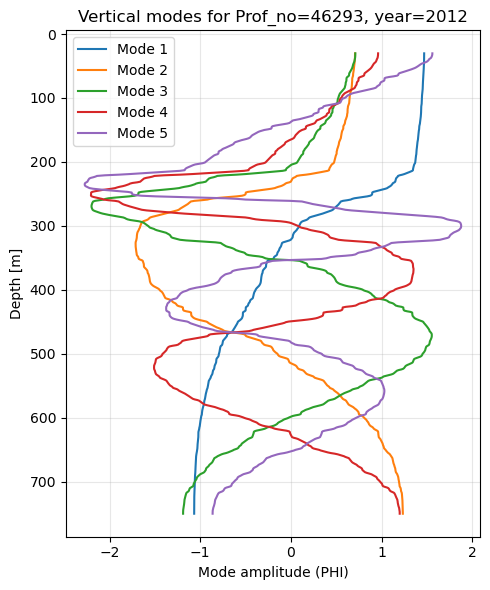

In [23]:
# EVP FOR INDIVIDUAL CAST
# For plotting purposes

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

year    = 2012      
prof_no = 46293       
Nm      = 5        # NOT the modes which are calculated, ONLY the modes being plotted 

#ChatGPT Extract said cast from dfN2 
df_year = dfN2.copy()
cast = (
    df_year[df_year["Prof_no"] == prof_no]
    .sort_values("Depth_[m]")
    .dropna(subset=["Depth_[m]", "N2_[s^-2]"])
)

if cast.empty:
    raise ValueError(f"Profile number {prof_no} not found in dfN2 for year {year}.")

# Get native mid-depths and N2 into float
z_mid = cast["Depth_[m]"].to_numpy(float)
N2_mid = cast["N2_[s^-2]"].to_numpy(float)

# Build regular z-grid as in modes_chelt_kelly
dz_native = np.diff(z_mid)
dz_med = float(np.median(dz_native)) if dz_native.size > 0 else np.nan
if not np.isfinite(dz_med) or dz_med <= 0:
    raise ValueError("Invalid dz_med for this cast.")

dz = dz_med
z_reg = np.arange(z_mid.min(), z_mid.max() + 0.5 * dz, dz)
N2_reg = np.interp(z_reg, z_mid, N2_mid)

# Solve EVP only for specific cast
PHI, C, PHI2 = modes_chelt_kelly(
    dz=dz,
    N2=N2_reg,
    Nm=Nm,
    include_mode0=False
)

print(f"Computed {len(C)} baroclinic modes (eigenspeeds):")
for i, cval in enumerate(C, start=1):
    print(f"Mode {i}: c_n = {cval:.3f} m/s")

plt.figure(figsize=(5, 6))
for i in range(PHI.shape[1]):
    plt.plot(PHI[:, i], z_reg, label=f"Mode {i+1}")

plt.gca().invert_yaxis()                   # Joke and Friederike argued in favor of inverting the y-axis. I suppose this is correct?
plt.xlabel("Mode amplitude (PHI)")
plt.ylabel("Depth [m]")
plt.title(f"Vertical modes for Prof_no={prof_no}, year={year}")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


The challenge in assesing the credibility of the phase speeds is the small amount of comparable sources online. So far I know only 2 papers and one lecture notes, where only the 2 papers go beyond a phrase like "we expect modes to be around..."

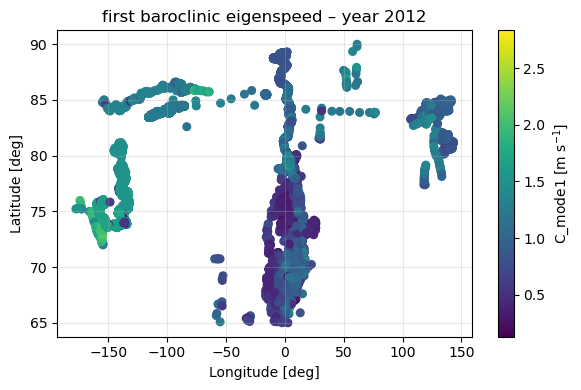

In [20]:
# Lat–lon maps of eigenspeeds for selected years

import matplotlib.pyplot as plt

years_to_plot = [2012]   # list of years to plot
mode_index = 1           # mode to be plotted

mode_col = f"C_mode{mode_index}"

if "df_modes" not in globals() or df_modes.empty:
    raise RuntimeError("df_modes is not available. Run the previous cell first.")

# Put that in a for loop to be able to study multiple years at once. 
# The most likely changes will be to MAYBE delete upper heights in the buoyancy frequency and to DEFINITELY filter through casts to
# better interpolate them soon, i.e. to limit the lat-lon limits to more polar-like regions.
for yr in years_to_plot:
    df_yr = df_modes[df_modes["year"] == yr].copy()

    if df_yr.empty or mode_col not in df_yr.columns:
        print(f"No data or no column {mode_col} for year {yr}.")
        continue

    # Drop casts where mode speed is missing
    df_yr = df_yr.dropna(subset=[mode_col])

    if df_yr.empty:
        print(f"All {mode_col} values are NaN for year {yr}.")
        continue

    plt.figure(figsize=(6, 4))
    sc = plt.scatter(
        df_yr["lon"],
        df_yr["lat"],
        c=df_yr[mode_col],
        s=30,
    )
    cbar = plt.colorbar(sc)
    cbar.set_label(f"{mode_col} [m s$^{{-1}}$]")

    plt.xlabel("Longitude [deg]")
    plt.ylabel("Latitude [deg]")

    if mode_index == 0:
        mode_name = "barotropic"
    elif mode_index == 1:
        mode_name = "first baroclinic"
    elif mode_index == 2:
        mode_name = "second baroclinic"
    else:
        mode_name = f"mode {mode_index}"

    plt.title(f"{mode_name} eigenspeed – year {yr}")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
